In [1]:
import time
import datetime
import os
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import scipy.stats as stats

import torch
import torch.multiprocessing as mp
from tqdm import tqdm

from deepsnap.graph import Graph as DSGraph
from deepsnap.batch import Batch

ModuleNotFoundError: No module named 'numpy'

In [2]:
class Utils:
    
    def get_timestamp(self):
        return datetime.datetime.now().strftime("%Y-%m-%dT%H:%M")
    
    def get_device(self, force_cpu=True):
        use_cuda = torch.cuda.is_available()
        use_mps = not use_cuda and torch.backends.mps.is_available()
    
        if not force_cpu and use_cuda:
            device = torch.device("cuda")
        elif not force_cpu and use_mps:
            device = torch.device("mps")
        else:
            device = torch.device("cpu")
    
        return device


    def generate_graph(self, size: int):
        return nx.binomial_graph(size, p=0.05, directed=False)
    
    def sample_neigh(self, graphs, size):
        ps = np.array([len(g) for g in graphs], dtype=float)
        ps /= np.sum(ps)
        dist = stats.rv_discrete(values=(np.arange(len(graphs)), ps))
        while True:
            idx = dist.rvs()
            #graph = random.choice(graphs)
            graph = graphs[idx]
            start_node = random.choice(list(graph.nodes))
            neigh = [start_node]
            frontier = list(set(graph.neighbors(start_node)) - set(neigh))
            visited = set([start_node])
            while len(neigh) < size and frontier:
                new_node = random.choice(list(frontier))
                assert new_node not in neigh
                neigh.append(new_node)
                visited.add(new_node)
                frontier += list(graph.neighbors(new_node))
                frontier = [x for x in frontier if x not in visited]
            if len(neigh) == size:
                return graph, neigh
    
    def batch_nx_graphs(self, graphs, anchors=None):

        #augmenter = feature_preprocess.FeatureAugment()
        
        if anchors is not None:
            for anchor, g in zip(anchors, graphs):
                for v in g.nodes:
                    g.nodes[v]["node_feature"] = torch.tensor([float(v == anchor)])
    
        batch = Batch.from_data_list([DSGraph(g) for g in graphs])
        #batch = augmenter.augment(batch)
        batch = batch.to(self.get_device())
        return batch
    
utils = Utils()

In [3]:
#import numpy as np
import random

SEED = 127
np.random.seed(SEED)

In [4]:
def plot_graph(G, with_label=False):
    plt.figure(figsize=(6, 4))
    node_size = 200
    if not with_label:
        node_size = node_size * 0.1
    nx.draw(G,
            pos=nx.spring_layout(G, seed=42),
            with_labels=with_label,
            node_color="skyblue",
            node_size=node_size,
            font_size=6,
            font_color="black",
            width=0.5,
            edge_color="gray")
    plt.title(f"Graph with {len(G.nodes)} nodes and {len(G.edges)} edges", size=10)
    plt.show()


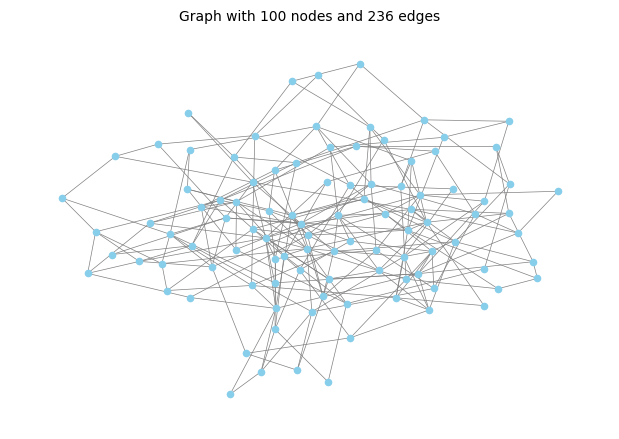

In [5]:
n = 1000
G = nx.binomial_graph(100, p=0.05, directed=False, seed=SEED)
plot_graph(G)

In [6]:
def random_subgraph(G, k):
    np.random.seed(SEED)
    random_node = np.random.choice(list(G.nodes()))
    return nx.ego_graph(G, random_node, radius=k)

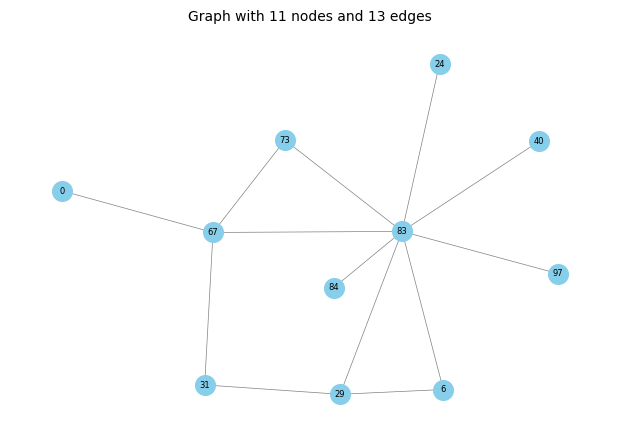

In [7]:
k = 2
G_target = random_subgraph(G, 2)
plot_graph(G_target, with_label=True)

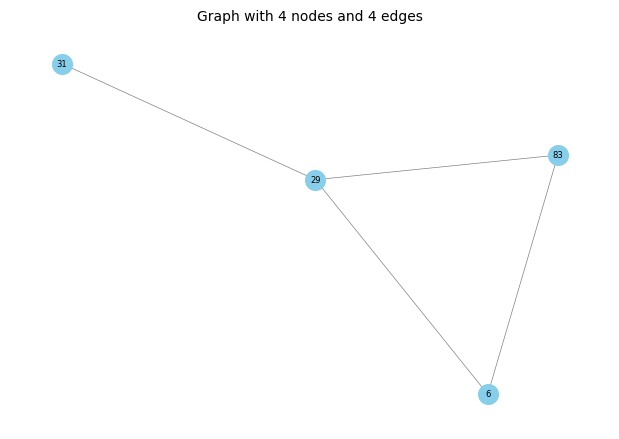

In [8]:
G_query_pos = random_subgraph(G_target, 1)
plot_graph(G_query_pos, with_label=True)

In [9]:
import copy

def inject_edge_errors(G, e: int = 1):
    np.random.seed(SEED)
    G_error = copy.deepcopy(G)

    for _ in range(e):
        modification_type = np.random.choice(['add', 'delete'])
        if modification_type == 'delete':
            if G_error.number_of_edges() > 0:
                idx_remove = np.random.randint(0, len(G_error.edges()))
                edge_to_remove = list(G_error.edges())[idx_remove]
                G_error.remove_edge(*edge_to_remove)
                print(f"Deleted edge: {edge_to_remove}")
        elif modification_type == 'add':
            possible_edges = list(nx.non_edges(G_error))  # Edges that do not currently exist
            if possible_edges:
                idx_add = np.random.randint(0, len(possible_edges))
                edge_to_add = possible_edges[idx_add]
                G_error.add_edge(*edge_to_add)
                print(f"Added new edge: {edge_to_add}")

    return G_error

Deleted edge: (83, 6)


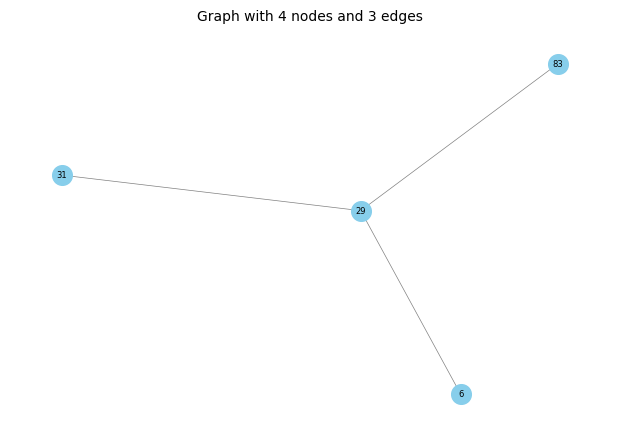

In [10]:
G_query_neg = inject_edge_errors(G_query_pos)
plot_graph(G_query_neg, with_label=True)

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

from deepsnap.batch import Batch
from deepsnap.dataset import GraphDataset
from torch.utils.data import DataLoader

In [12]:
class Args:
    conv_type = 'graph'
    method_type = 'order'
    dataset = 'syn'
    n_layers = 4
    batch_size = 64
    hidden_dim = 64
    skip = "learnable"
    dropout = 0.0
    n_batches = 100000
    opt = 'adam'
    opt_scheduler = 'none'
    opt_restart = 100
    weight_decay = 0.0
    lr = 1e-4
    margin = 0.1
    test_set = ''
    eval_interval = 1000
    n_workers = 4
    model_path = "ckpt/model.pt"
    tag = ''
    val_size = 2048
    node_anchored = True
    test = False

In [13]:
class SkipLastGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args: Args):
        super(SkipLastGNN, self).__init__()
        self.dropout = args.dropout
        self.n_layers = args.n_layers

        self.feat_preprocess = None  # TODO check for reason

        self.pre_mp = nn.Sequential(nn.Linear(input_dim, hidden_dim))

        conv_model = self.build_conv_model(args.conv_type, 1)
        self.convs = nn.ModuleList()

        if args.skip == 'learnable':  # TODO check for reason
            self.learnable_skip = nn.Parameter(torch.ones(self.n_layers, self.n_layers))

        for layer in range(args.n_layers):
            if args.skip == 'all' or args.skip == 'learnable':
                hidden_input_dim = hidden_dim * (layer + 1)
            else:
                hidden_input_dim = hidden_dim

            self.convs.append(conv_model(hidden_input_dim, hidden_dim))

        post_input_dim = hidden_dim * (args.n_layers + 1)
        self.post_mp = nn.Sequential(
            nn.Linear(post_input_dim, hidden_dim), nn.Dropout(args.dropout),
            nn.LeakyReLU(0.1),
            nn.Linear(hidden_dim, output_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 256), nn.ReLU(),
            nn.Linear(256, hidden_dim))

        self.skip = args.skip
        self.conv_type = args.conv_type

    def build_conv_model(self, model_type, n_inner_layers):
        if model_type == "GCN":
            return pyg_nn.GCNConv
        elif model_type == "graph":
            return pyg_nn.GraphConv
        elif model_type == "GAT":
            return pyg_nn.GATConv
        else:
            print("unrecognized model type")

    def forward(self, data):
        if self.feat_preprocess is not None:
            if not hasattr(data, "preprocessed"):
                data = self.feat_preprocess(data)
                data.preprocessed = True
        x, edge_index, batch = data.node_feature, data.edge_index, data.batch
        x = self.pre_mp(x)

        all_emb = x.unsqueeze(1)
        emb = x
        for i in range(len(self.convs)):
            if self.skip == 'learnable':
                skip_vals = self.learnable_skip[i, :i + 1].unsqueeze(0).unsqueeze(-1)
                curr_emb = all_emb * torch.sigmoid(skip_vals)
                curr_emb = curr_emb.view(x.size(0), -1)
                x = self.convs[i](curr_emb, edge_index)
            elif self.skip == 'all':
                x = self.convs[i](emb, edge_index)
            else:
                x = self.convs[i](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            emb = torch.cat((emb, x), 1)
            if self.skip == 'learnable':
                all_emb = torch.cat((all_emb, x.unsqueeze(1)), 1)

        emb = pyg_nn.global_add_pool(emb, batch)
        emb = self.post_mp(emb)
        return emb

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

In [14]:
class OrderEmbedder(nn.Module):
    def __init__(self, input_dim, hidden_dim, args: Args):
        super(OrderEmbedder, self).__init__()
        self.emb_model = SkipLastGNN(input_dim, hidden_dim, hidden_dim, args)
        self.margin = args.margin
        self.use_intersection = False

        self.clf_model = nn.Sequential(nn.Linear(1, 2), nn.LogSoftmax(dim=-1))

    def forward(self, emb_as, emb_bs):
        return emb_as, emb_bs

    def predict(self, pred):
        """Predict if b is a subgraph of a (batched), where emb_as, emb_bs = pred.

        pred: list (emb_as, emb_bs) of embeddings of graph pairs

        Returns: list of bools (whether a is subgraph of b in the pair)
        """
        emb_as, emb_bs = pred
        e = torch.sum(torch.max(torch.zeros_like(emb_as, device=emb_as.device), emb_bs - emb_as) ** 2, dim=1)
        return e

    def criterion(self, pred, intersect_embs, labels):
        """Loss function for order emb.
        The e term is the amount of violation (if b is a subgraph of a).
        For positive examples, the e term is minimized (close to 0); 
        for negative examples, the e term is trained to be at least greater than self.margin.

        pred: lists of embeddings outputted by forward
        intersect_embs: not used
        labels: subgraph labels for each entry in pred
        """
        emb_as, emb_bs = pred
        e = torch.sum(torch.max(torch.zeros_like(emb_as, device=utils.get_device()), emb_bs - emb_as) ** 2, dim=1)

        margin = self.margin
        e[labels == 0] = torch.max(torch.tensor(0.0, device=utils.get_device()), margin - e)[labels == 0]

        relation_loss = torch.sum(e)

        return relation_loss

In [15]:
import torch.optim as optim
import torchinfo
from torch.utils.tensorboard import SummaryWriter

In [16]:
def build_model(args: Args) -> nn.Module:
    model = OrderEmbedder(1, args.hidden_dim, args)
    model.to(utils.get_device())
    if args.test and args.model_path:
        model.load_state_dict(torch.load(args.model_path, map_location=utils.get_device(), weights_only=False))
    return model

In [17]:
def build_optimizer(model: nn.Module, args: Args) -> optim.Optimizer:
    weight_decay = args.weight_decay
    filter_fn = filter(lambda p: p.requires_grad, model.parameters())
    if args.opt == 'adam':
        optimizer = optim.Adam(filter_fn, lr=args.lr, weight_decay=weight_decay)
    return optimizer

In [18]:
def get_dataset():
    task = "graph"
    dataset = []
    for i in range(10):
        dataset.append( utils.generate_graph( 100 ) )
        
    train_len = int(0.8 * len(dataset))
    train, test = [], []
    random.shuffle(dataset)
    for i, graph in enumerate(dataset):
        if i < train_len:
            train.append(graph)
        else:
            test.append(graph)
    return train, test, task

In [19]:
def gen_data_loaders(size: int, batch_size: int):
    loaders = [[batch_size]*(size // batch_size) for i in range(3)]
    return loaders

In [20]:
def gen_batch(dataset, a, b, c, train, node_anchored=True, filter_negs=False, max_size=15, min_size=5, batched=True ):
    batch_size = a
    train_set, test_set, task = dataset
    graphs = train_set if train else test_set

    # pos 
    pos_target, pos_query = [], []
    pos_target_anchors, pos_query_anchors = [], []
    for i in range(batch_size // 2):
        # tree-pair
        size = random.randint(min_size+1, max_size)
        graph, a = utils.sample_neigh(graphs, size)
        b = a[:random.randint(min_size, len(a) - 1)]
        if node_anchored:
            anchor = list(graph.nodes)[0]
            pos_target_anchors.append(anchor)
            pos_query_anchors.append(anchor)
        neigh_target, neigh_query = graph.subgraph(a), graph.subgraph(b)
        pos_target.append(neigh_target)
        pos_query.append(neigh_query)

    # neg 
    neg_target, neg_query = [], []
    neg_target_anchors, neg_query_anchors = [], []
    while len(neg_target) < batch_size // 2:
        # tree-pair
        size = random.randint(min_size+1, max_size)
        graph_a, a = utils.sample_neigh(graphs, size)
        graph_b, b = utils.sample_neigh(graphs, random.randint(min_size, size - 1))
        if node_anchored:
            neg_target_anchors.append(list(graph_a.nodes)[0])
            neg_query_anchors.append(list(graph_b.nodes)[0])
        neigh_target, neigh_query = graph_a.subgraph(a), graph_b.subgraph(b)
        if filter_negs:
            matcher = nx.algorithms.isomorphism.GraphMatcher(neigh_target, neigh_query)
            if matcher.subgraph_is_isomorphic(): # a <= b (b is subgraph of a)
                continue
        neg_target.append(neigh_target)
        neg_query.append(neigh_query)
        
    if not batched:
        return pos_target, pos_query, neg_target, neg_query

    # to batches 
    pos_target = utils.batch_nx_graphs(pos_target, anchors=pos_target_anchors if node_anchored else None)
    pos_query = utils.batch_nx_graphs(pos_query, anchors=pos_query_anchors if node_anchored else None)
    neg_target = utils.batch_nx_graphs(neg_target, anchors=neg_target_anchors if node_anchored else None)
    neg_query = utils.batch_nx_graphs(neg_query, anchors=neg_query_anchors if node_anchored else None)
    return pos_target, pos_query, neg_target, neg_query

In [21]:
args = Args()
dataset = get_dataset()
loaders = gen_data_loaders(args.eval_interval * args.batch_size, args.batch_size)
for batch_target, batch_neg_target, batch_neg_query in zip(*loaders):
    
    print(batch_target, batch_neg_target, batch_neg_query)
    
    pos_target, pos_query, neg_target, neg_query = gen_batch( dataset, batch_target, batch_neg_target, batch_neg_query, True )
    print(pos_target)
    print(pos_query)
    print(neg_target)
    print(neg_query)
    
    break

64 64 64
Batch(G=[32], batch=[348], edge_index=[2, 742], edge_label_index=[2, 742], node_feature=[348, 1], node_label_index=[348])
Batch(G=[32], batch=[219], edge_index=[2, 410], edge_label_index=[2, 410], node_feature=[219, 1], node_label_index=[219])
Batch(G=[32], batch=[323], edge_index=[2, 682], edge_label_index=[2, 682], node_feature=[323, 1], node_label_index=[323])
Batch(G=[32], batch=[223], edge_index=[2, 426], edge_label_index=[2, 426], node_feature=[223, 1], node_label_index=[223])


In [22]:
def train(model: nn.Module, dataset, args: Args):
    
    optimizer = build_optimizer(model, args)
    clf_opt = optim.Adam(model.clf_model.parameters(), lr=args.lr)
    
    loaders = gen_data_loaders(args.eval_interval * args.batch_size, args.batch_size)
    batch_count = len(loaders[0])
    
    train_loss = 0
    train_acc = 0
    
    current_batch = 0
    for batch_target, batch_neg_target, batch_neg_query in zip(*loaders):
     
        model.train()
        model.zero_grad()
        pos_target, pos_query, neg_target, neg_query = gen_batch( dataset, batch_target, batch_neg_target, batch_neg_query, True )
        emb_pos_target, emb_pos_query = model.emb_model(pos_target), model.emb_model(pos_query)
        emb_neg_target, emb_neg_query = model.emb_model(neg_target), model.emb_model(neg_query)
        
        emb_targets = torch.cat((emb_pos_target, emb_neg_target), dim=0)
        emb_queries = torch.cat((emb_pos_query, emb_neg_query), dim=0)
        labels = torch.tensor([1]*pos_target.num_graphs + [0]*neg_target.num_graphs).to(utils.get_device())
        
        pred = model(emb_targets, emb_queries)
        loss = model.criterion(pred, None, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        with torch.no_grad():
            pred = model.predict(pred)
            
        model.clf_model.zero_grad()
        pred = model.clf_model(pred.unsqueeze(1))
        criterion = nn.NLLLoss()
        clf_loss = criterion(pred, labels)
        clf_loss.backward()
        clf_opt.step()
            
        pred = pred.argmax(dim=-1)
        acc = torch.mean((pred == labels).type(torch.float))
        train_loss += loss.item()
        train_acc += acc.item()
        
        current_batch += 1
        if current_batch % 10 == 0:
            print( f"Finished batch {current_batch}/{batch_count}: loss: {loss.item():.4f} / accuracy: {acc.item():.4f}" )
        
    return train_loss / batch_count, train_acc / batch_count

In [23]:
from sklearn.metrics import roc_auc_score, confusion_matrix, average_precision_score

def validate(args: Args, model: nn.Module, dataset):
    print( f"Starting validation ..." )
    
    loaders = gen_data_loaders(args.val_size, args.batch_size)
    test_pts = []
    for batch_target, batch_neg_target, batch_neg_query in zip(*loaders):
        test_pts.append(gen_batch( dataset, batch_target, batch_neg_target, batch_neg_query, True ))
    
    model.eval()
    all_raw_preds, all_preds, all_labels = [], [], []
    for pos_a, pos_b, neg_a, neg_b in test_pts:
        if pos_a:
            pos_a = pos_a.to(utils.get_device())
            pos_b = pos_b.to(utils.get_device())
        neg_a = neg_a.to(utils.get_device())
        neg_b = neg_b.to(utils.get_device())
        labels = torch.tensor([1]*(pos_a.num_graphs if pos_a else 0) + [0]*neg_a.num_graphs).to(utils.get_device())
        with torch.no_grad():
            
            emb_neg_a, emb_neg_b = (model.emb_model(neg_a), model.emb_model(neg_b))
            
            if pos_a:
                emb_pos_a, emb_pos_b = (model.emb_model(pos_a),model.emb_model(pos_b))
                emb_as = torch.cat((emb_pos_a, emb_neg_a), dim=0)
                emb_bs = torch.cat((emb_pos_b, emb_neg_b), dim=0)
            else:
                emb_as, emb_bs = emb_neg_a, emb_neg_b
                
            pred = model(emb_as, emb_bs)
            raw_pred = model.predict(pred)

            pred = model.clf_model(raw_pred.unsqueeze(1)).argmax(dim=-1)
            raw_pred *= -1
            
        all_raw_preds.append(raw_pred)
        all_preds.append(pred)
        all_labels.append(labels)
        
    pred = torch.cat(all_preds, dim=-1)
    labels = torch.cat(all_labels, dim=-1)
    raw_pred = torch.cat(all_raw_preds, dim=-1)
    acc = torch.mean((pred == labels).type(torch.float))
    prec = (torch.sum(pred * labels).item() / torch.sum(pred).item() if torch.sum(pred) > 0 else float("NaN"))
    recall = (torch.sum(pred * labels).item() / torch.sum(labels).item() if torch.sum(labels) > 0 else float("NaN"))
    labels = labels.detach().cpu().numpy()
    raw_pred = raw_pred.detach().cpu().numpy()
    pred = pred.detach().cpu().numpy()
    auroc = roc_auc_score(labels, raw_pred)
    avg_prec = average_precision_score(labels, raw_pred)
    tn, fp, fn, tp = confusion_matrix(labels, pred).ravel()

    return acc, prec, recall, auroc, avg_prec, tn, fp, fn, tp

In [24]:
args = Args()
if not os.path.exists(os.path.dirname(args.model_path)):
    os.makedirs(os.path.dirname(args.model_path))
    
model = build_model(args)
print(torchinfo.summary(model))
dataset = get_dataset()

record_keys = ["conv_type", "n_layers", "hidden_dim", "margin"]
args_str = ".".join(["{}={}".format(k, v) for k, v in sorted(vars(args).items()) if k in record_keys])
logger = SummaryWriter(log_dir=f'runs/{args.conv_type}{args.n_layers}_{utils.get_timestamp()}', comment=args_str)

if args.test:
    print( "starting test ..." )
    results = validate(args, model, dataset)
    acc, prec, recall, auroc, avg_prec, tn, fp, fn, tp = results
    print("Testing. Acc: {:.4f}. "
    "P: {:.4f}. R: {:.4f}. AUROC: {:.4f}. AP: {:.4f}.\n"
    "TN: {}. FP: {}. FN: {}. TP: {}".format(
        acc, prec, recall, auroc, avg_prec,
        tn, fp, fn, tp))
else:
    epochs = args.n_batches // args.eval_interval
    for epoch in range(epochs):
        
        # train
        print( f"starting epoch {epoch}/{epochs} ..." )
        loss, acc = train(model, dataset, args)
        logger.add_scalar('train/loss', loss, epoch)
        logger.add_scalar('train/accuracy', acc, epoch)
        print( f"finished epoch {epoch}/{epochs}: loss: {loss:.4f} / accuracy {acc:.4f}" )
        
        # validate
        results = validate(args, model, dataset)
        acc, prec, recall, auroc, avg_prec, tn, fp, fn, tp = results
        print("Validation. Epoch {}. Acc: {:.4f}. "
        "P: {:.4f}. R: {:.4f}. AUROC: {:.4f}. AP: {:.4f}.\n"
        "TN: {}. FP: {}. FN: {}. TP: {}".format(epoch,
            acc, prec, recall, auroc, avg_prec,
            tn, fp, fn, tp))
        logger.add_scalar("test/accuracy", acc, epoch)
        logger.add_scalar("test/precision", prec, epoch)
        logger.add_scalar("test/recall", recall, epoch)
        logger.add_scalar("test/auroc", auroc, epoch)
        logger.add_scalar("test/avg_prec", avg_prec, epoch)
        logger.add_scalar("test/TP", tp, epoch)
        logger.add_scalar("test/TN", tn, epoch)
        logger.add_scalar("test/FP", fp, epoch)
        logger.add_scalar("test/FN", fn, epoch)
        
        torch.save(model.state_dict(), args.model_path)

Layer (type:depth-idx)                        Param #
OrderEmbedder                                 --
├─SkipLastGNN: 1-1                            16
│    └─Sequential: 2-1                        --
│    │    └─Linear: 3-1                       128
│    └─ModuleList: 2-2                        --
│    │    └─GraphConv: 3-2                    8,256
│    │    └─GraphConv: 3-3                    16,448
│    │    └─GraphConv: 3-4                    24,640
│    │    └─GraphConv: 3-5                    32,832
│    └─Sequential: 2-3                        --
│    │    └─Linear: 3-6                       20,544
│    │    └─Dropout: 3-7                      --
│    │    └─LeakyReLU: 3-8                    --
│    │    └─Linear: 3-9                       4,160
│    │    └─ReLU: 3-10                        --
│    │    └─Linear: 3-11                      16,640
│    │    └─ReLU: 3-12                        --
│    │    └─Linear: 3-13                      16,448
├─Sequential: 1-2                

KeyboardInterrupt: 

In [ ]:
def train(model: nn.Module, dataset, args: Args, in_queue: mp.Queue, out_queue: mp.Queue):
    
    optimizer = build_optimizer(model, args)
    clf_opt = optim.Adam(model.clf_model.parameters(), lr=args.lr)
    
    done = False
    while not done:
        
        loaders = gen_data_loaders(args.eval_interval * args.batch_size, args.batch_size)
        for batch_target, batch_neg_target, batch_neg_query in zip(*loaders):
            
            msg, _ = in_queue.get()
            if msg == "done":
                done = True
                break
         
            model.train()
            model.zero_grad()
            pos_target, pos_query, neg_target, neg_query = gen_batch( dataset, batch_target, batch_neg_target, batch_neg_query, True )
            emb_pos_target, emb_pos_query = model.emb_model(pos_target), model.emb_model(pos_query)
            emb_neg_target, emb_neg_query = model.emb_model(neg_target), model.emb_model(neg_query)
            
            emb_targets = torch.cat((emb_pos_target, emb_neg_target), dim=0)
            emb_queries = torch.cat((emb_pos_query, emb_neg_query), dim=0)
            labels = torch.tensor([1]*pos_target.num_graphs + [0]*neg_target.num_graphs).to(utils.get_device())
            
            pred = model(emb_targets, emb_queries)
            loss = model.criterion(pred, None, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            with torch.no_grad():
                pred = model.predict(pred)
                
            model.clf_model.zero_grad()
            pred = model.clf_model(pred.unsqueeze(1))
            criterion = nn.NLLLoss()
            clf_loss = criterion(pred, labels)
            clf_loss.backward()
            clf_opt.step()
                
            pred = pred.argmax(dim=-1)
            acc = torch.mean((pred == labels).type(torch.float))
            
            out_queue.put(("step", (loss.item(), acc.item())))

mp.set_start_method("spawn", force=True)
print("Starting {} workers".format(args.n_workers))
in_queue, out_queue = mp.Queue(), mp.Queue()

args = Args()
if not os.path.exists(os.path.dirname(args.model_path)):
    os.makedirs(os.path.dirname(args.model_path))
    
model = build_model(args)
print(torchinfo.summary(model))
model.share_memory()
dataset = get_dataset()

record_keys = ["conv_type", "n_layers", "hidden_dim", "margin"]
args_str = ".".join(["{}={}".format(k, v) for k, v in sorted(vars(args).items()) if k in record_keys])
logger = SummaryWriter(log_dir=f'runs/{args.conv_type}{args.n_layers}_{utils.get_timestamp()}', comment=args_str)

if args.test:
    print( "starting test ..." )
    results = validate(args, model, dataset)
    acc, prec, recall, auroc, avg_prec, tn, fp, fn, tp = results
    print("Testing. Acc: {:.4f}. "
    "P: {:.4f}. R: {:.4f}. AUROC: {:.4f}. AP: {:.4f}.\n"
    "TN: {}. FP: {}. FN: {}. TP: {}".format(
        acc, prec, recall, auroc, avg_prec,
        tn, fp, fn, tp))
else:
    
    workers = []
    for i in range(args.n_workers):
        worker = mp.Process(target=train, args=(model, dataset, args, in_queue, out_queue))
        worker.start()
        workers.append(worker)
    
    batch_n = 0
    epochs = args.n_batches // args.eval_interval
    for epoch in range(epochs):
        
        epoch_loss = 0
        epoch_acc = 0
        
        # train
        for i in range(args.eval_interval):
            in_queue.put(("step", None))
        for i in range(args.eval_interval):
            msg, params = out_queue.get()
            loss, acc = params
            epoch_loss += loss
            epoch_acc = acc
            print("Training Epoch {} [Batch {}] - Loss: {:.4f} / Accuracy: {:.4f}".format(epoch, batch_n, loss, acc), end="               \r")
            logger.add_scalar('train/loss', loss, epoch)
            logger.add_scalar('train/accuracy', acc, epoch)
            batch_n += 1
            
        print( f"Finished Epoch {epoch}/{epochs}: Loss: {loss:.4f} / Accuracy: {acc:.4f}" )
            
        # validate
        results = validate(args, model, dataset)
        acc, prec, recall, auroc, avg_prec, tn, fp, fn, tp = results
        print("Validation Epoch {} - Acc: {:.4f}. "
        "P: {:.4f}. R: {:.4f}. AUROC: {:.4f}. AP: {:.4f}.\n"
        "TN: {}. FP: {}. FN: {}. TP: {}".format(epoch,
            acc, prec, recall, auroc, avg_prec,
            tn, fp, fn, tp))
        logger.add_scalar("test/accuracy", acc, epoch)
        logger.add_scalar("test/precision", prec, epoch)
        logger.add_scalar("test/recall", recall, epoch)
        logger.add_scalar("test/auroc", auroc, epoch)
        logger.add_scalar("test/avg_prec", avg_prec, epoch)
        logger.add_scalar("test/TP", tp, epoch)
        logger.add_scalar("test/TN", tn, epoch)
        logger.add_scalar("test/FP", fp, epoch)
        logger.add_scalar("test/FN", fn, epoch)
        
        torch.save(model.state_dict(), args.model_path)
        
    for i in range(args.n_workers):
        in_queue.put(("done", None))
    for worker in workers:
        worker.join()

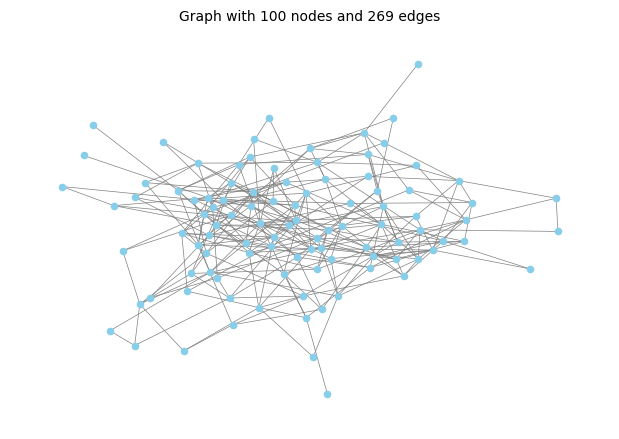

In [25]:
test_args = Args()
test_args.test = True

test_model = build_model(test_args)
test_dataset = get_dataset()
test_dataset_example = test_dataset[1][0]

plot_graph(test_dataset_example)

In [26]:
test_loaders = gen_data_loaders(args.val_size, args.batch_size)
example_batch = None
example_batch_graphs = None
for batch_target, batch_neg_target, batch_neg_query in zip(*test_loaders):
    example_batch = gen_batch( test_dataset, batch_target, batch_neg_target, batch_neg_query, True )
    example_batch_graphs = gen_batch( test_dataset, batch_target, batch_neg_target, batch_neg_query, True, batched=False )
    break
   
pos_target_graph, pos_query_graph, neg_target_graph, neg_query_graph = example_batch_graphs 
pos_target, pos_query, neg_target, neg_query = example_batch

test_labels = torch.tensor([1]*(pos_target.num_graphs if neg_target else 0) + [0]*neg_target.num_graphs).to(utils.get_device())
test_model.eval()
with torch.no_grad():
    
    emb_pos_target, emb_pos_query = test_model.emb_model(pos_target), test_model.emb_model(pos_query)
    emb_neg_target, emb_neg_query = test_model.emb_model(neg_target), test_model.emb_model(neg_query)
    
    emb_targets = torch.cat((emb_pos_target, emb_neg_target), dim=0)
    emb_queries = torch.cat((emb_pos_query, emb_neg_query), dim=0)
                
    pred = model(emb_targets, emb_queries)
    raw_pred = model.predict(pred)
    
    pred = model.clf_model(raw_pred.unsqueeze(1)).argmax(dim=-1)
    raw_pred *= -1
    
print(pred)
print(raw_pred)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1,
        0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])
tensor([-9.0460e-08, -1.7525e-03, -3.9040e-03, -2.8868e-02, -2.3165e-02,
        -1.4073e-02, -0.0000e+00, -5.8648e-02, -6.2877e-04, -1.7835e-02,
        -0.0000e+00, -0.0000e+00, -3.7397e-03, -3.0970e-03, -7.2932e-06,
        -9.4299e-02, -3.2417e-02, -1.6754e-03, -1.6182e-04, -9.3593e-03,
        -3.9242e-03, -4.2709e-05, -7.1309e-04, -9.5815e-05, -5.3414e-03,
        -3.7381e-02, -2.3078e-03, -1.9045e-02, -4.5698e-03, -1.0950e-02,
        -1.0868e-02, -1.4059e-02, -3.7779e-01, -1.7266e-02, -4.5236e-04,
        -8.4457e+00, -1.8119e-02, -1.6675e+00, -7.8183e-03, -4.5479e-02,
        -2.2805e-03, -5.2220e-01, -1.4783e+00, -2.7688e-01, -6.2783e-01,
        -6.7771e-04, -8.1328e-01, -3.7172e-03, -2.3685e+00, -1.4659e-02,
        -3.3424e-02, -2.0809e-03, -0.0000e+00, -0.000

In [27]:
test_idx = 0

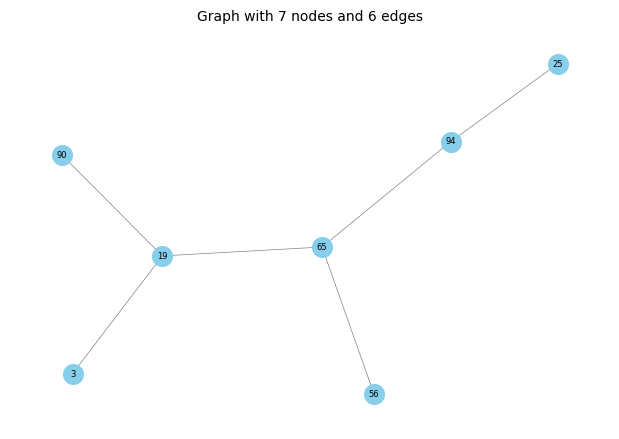

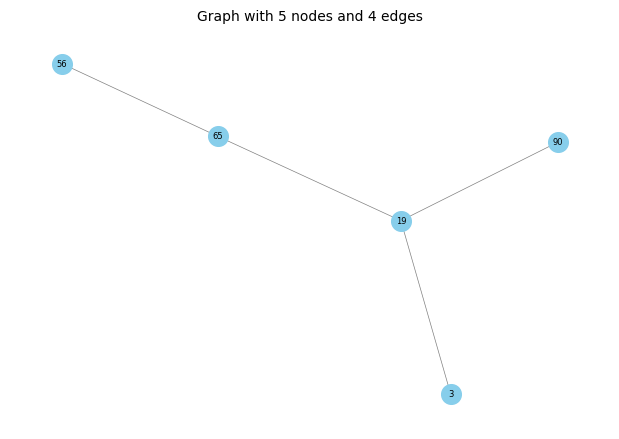

Is query is subgraph - model: True / actual  True


In [28]:
plot_graph(pos_target_graph[test_idx], with_label=True)
plot_graph(pos_query_graph[test_idx], with_label=True)
print(f"Is query is subgraph - model: {pred[test_idx] == True} / actual  {test_labels[test_idx] == True}")

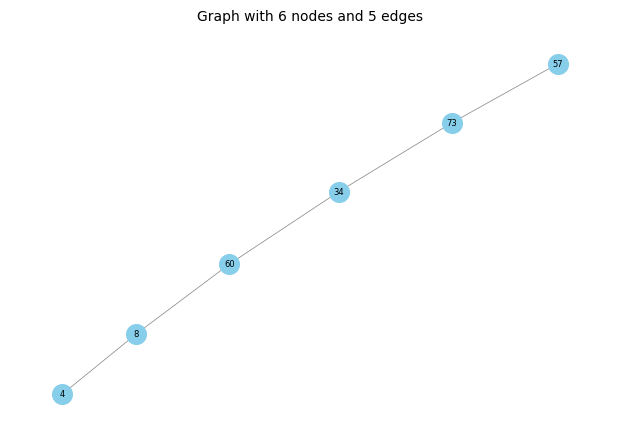

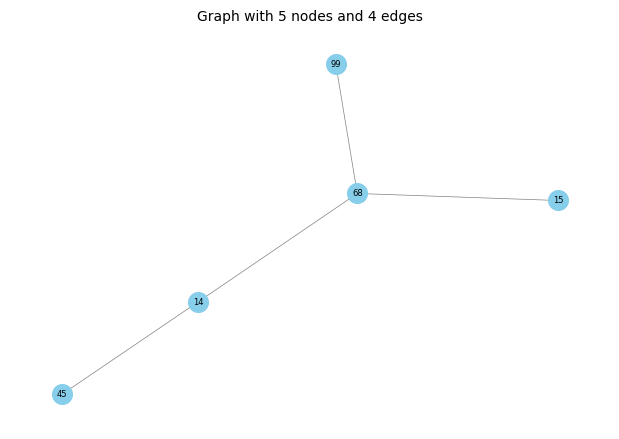

Is query is subgraph - model: False / actual: False


In [29]:
plot_graph(neg_target_graph[test_idx], with_label=True)
plot_graph(neg_query_graph[test_idx], with_label=True)
print(f"Is query is subgraph - model: {pred[len(pos_target_graph) + test_idx] == True} / actual: {test_labels[len(pos_target_graph) + test_idx] == True}")